<a href="https://www.kaggle.com/code/acorn8/q-a-with-llms-harry-potter-mistral-hf-api?scriptVersionId=145889852" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Credits
[Original Kaggle notebook](https://www.kaggle.com/code/hinepo/q-a-chatbot-with-llms-harry-potter) by [HinePo](https://www.kaggle.com/hinepo)

- Modified to use the Mistral Instruct model (Free Hugging Face API call)
- Requires a free [Hugging Face user access token](https://huggingface.co/docs/hub/security-tokens)

# About

- Use [Langchain](https://python.langchain.com/en/latest/index.html) to build a chatbot that can answer questions about [Harry Potter books](https://www.kaggle.com/datasets/hinepo/harry-potter-books-in-pdf-1-7)
- Use [FAISS vector store](https://python.langchain.com/docs/integrations/vectorstores/faiss) to store text embeddings with [Sentence Transformers](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) from [Hugging Face](https://huggingface.co/hkunlp/instructor-large)
- Use free Kaggle GPU to run FAISS
- Use [Retrieval chain](https://python.langchain.com/docs/modules/data_connection/retrievers/) to retrieve relevant passages from embedded text
- Summarize retrieved passages

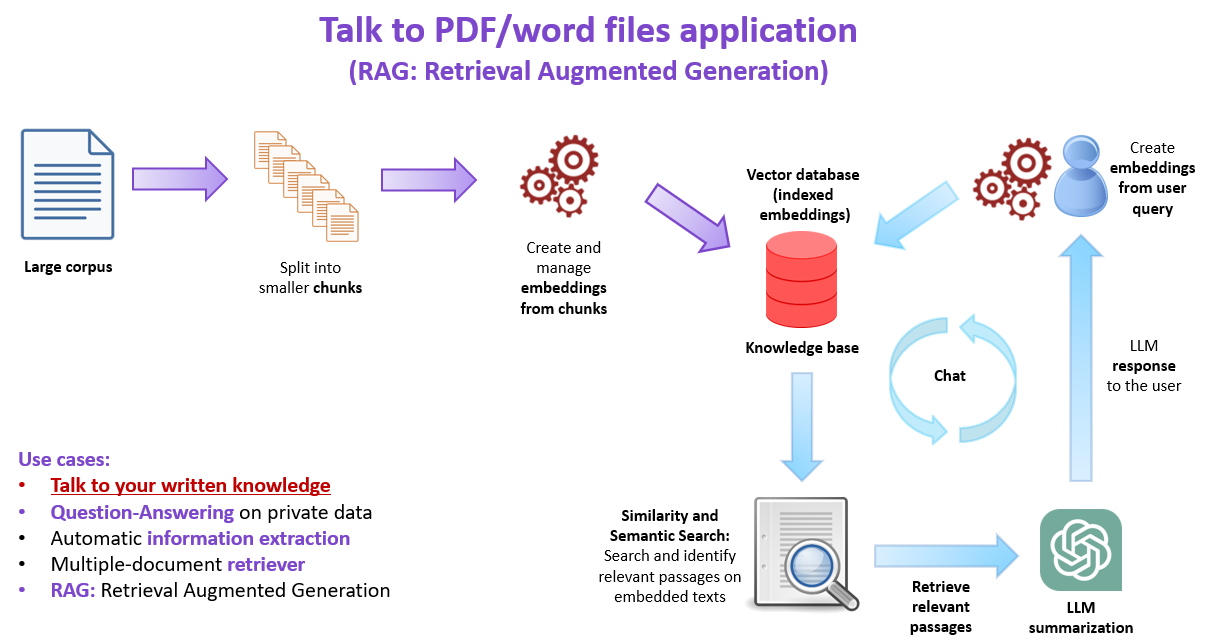

img source: HinePo

# Installs

In [1]:
%%time

! pip install -q -U langchain pypdf faiss-gpu
! pip install -q -U InstructorEmbedding sentence_transformers
! pip install huggingface_hub -q
! pip install gradio -q
! pip install watermark -q

CPU times: user 1.18 s, sys: 209 ms, total: 1.39 s
Wall time: 1min 14s


In [2]:
%load_ext watermark

In [3]:
%watermark

Last updated: 2023-10-09T22:07:46.141028+00:00

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.13.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 6.1.42+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



# Imports

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import textwrap
import time

import langchain

# loaders
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader

# splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

# prompts
from langchain import PromptTemplate, LLMChain

# vector stores
from langchain.vectorstores import FAISS

# models
from langchain.llms import HuggingFacePipeline
from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

# retrievers
from langchain.chains import RetrievalQA

import torch

In [5]:
%watermark --iversions

langchain: 0.0.311
torch    : 2.0.0



# CFG

- CFG class enables easy and organized experimentation 

In [6]:
class CFG:
    # LLMs
    model_name = 'mistralai/Mistral-7B-Instruct-v0.1'
    temperature = 0.5
    top_p = 0.95
    repetition_penalty = 1.15
    do_sample = True
    max_new_tokens = 1024
    num_return_sequences=1

    # splitting
    split_chunk_size = 800
    split_overlap = 0
    
    # embeddings
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'

    # similar passages
    k = 3
    
    # paths
    PDFs_path = '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/'
    # PDFs_path = '/kaggle/input/data-visualization-cheat-cheats-and-resources/Data visualizaion Books'
    Embeddings_path =  '/kaggle/input/faiss-hp-sentence-transformers'
    Persist_directory = './harry-potter-vectordb'
    # Persist_directory = './data-viz-vectordb'

# Define model

In [7]:
# Create a free read HF token: https://huggingface.co/settings/tokens
# Use Kaggle Secrets: Add-ons, Secrets, add secret

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
huggingfacehub_api_token = user_secrets.get_secret("hf_token")

In [8]:
from langchain.llms import HuggingFaceHub

llm = HuggingFaceHub(
    repo_id = CFG.model_name,
    model_kwargs={
        "max_new_tokens": CFG.max_new_tokens,
        "temperature": CFG.temperature,
        "top_p": CFG.top_p,
        "repetition_penalty": CFG.repetition_penalty,
        "do_sample": CFG.do_sample,
        "num_return_sequences": CFG.num_return_sequences        
    },
    huggingfacehub_api_token = huggingfacehub_api_token
)

In [9]:
# We use the prompt template used to train the Mistral Instruct model
# See https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1
print(llm("""<s>[INST] Give me 5 examples of cool potions and explain what they do. [/INST]""", raw_response=True).strip())

1) Love Potion: This is a popular potion among romantic creatures, which makes the drinker fall deeply in love with someone else. It works by altering the chemistry of the brain to increase feelings of attraction and affection towards another being.
2) Invisibility Potion: This potion renders its consumer invisible, making them unseen by the naked eye. It does this by disrupting light waves around the body, preventing them from being detected.
3) Healing Potion: This powerful potion restores health and vitality to those who consume it. It works by repairing damaged cells and tissues within the body, as well as boosting the immune system to fight off illnesses.
4) Mind Control Potion: This potion allows its user to control the thoughts and actions of others. It achieves this by manipulating neurotransmitters in the brain, causing the victim to become under the influence of the potion's maker.
5) Time Travel Potion: With this rare and dangerous potion, the drinker can travel through time

## Loader

- [Directory loader](https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory) for multiple files
- This step is not necessary if you are just loading the vector database
- This step is necessary if you are creating embeddings. In this case you need to:
    - load de PDF files
    - split into chunks
    - create embeddings
    - save the embeddings in a vector store
    - After that you can just load the saved embeddings to do similarity search with the user query, and then use the LLM to answer the question

In [10]:
%%time

loader = DirectoryLoader(
    CFG.PDFs_path,
    glob="./*.pdf",
    loader_cls=PyPDFLoader,
    show_progress=True,
    use_multithreading=True
)

documents = loader.load()

100%|██████████| 7/7 [01:26<00:00, 12.41s/it]

CPU times: user 1min 26s, sys: 2 s, total: 1min 28s
Wall time: 1min 26s


In [11]:
print(f'We have {len(documents)} pages in total')

We have 4114 pages in total


In [12]:
documents[8].page_content

"8Ron\nP.S. Percy's Head Boy. He got the letter last week.Harry glanced back at the photograph. Percy, who was in his seventh and\nfinal year at Hogwarts, was looking particularly smug. He had pinned hisHead Boy badge to the fez perched jauntily on top of his neat hair, hishorn-rimmed glasses flashing in the Egyptian sun.\nHarry now turned to his present and unwrapped it. Inside was what looked\nlike a miniature glass spinning top. There was another note from Ronbeneath it.\nHarry -- this is a Pocket Sneakoscope. If there's someone untrustworthy\naround, it's supposed to light up and spin. Bill says it's rubbish soldfor wizard tourists and isn't reliable, because it kept lighting up atdinner last night. But he didn't realize Fred and George had put beetlesin his soup.\nBye --RonHarry put the Pocket Sneakoscope on his bedside table, where it stood\nquite still, balanced on its point, reflecting the luminous hands of hisclock. He looked at it happily for a few seconds, then picked up the

## Splitter

- Splitting the text into chunks so its passages are easily searchable for similarity
- This step is also only necessary if you are creating the embeddings
- [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/reference/modules/document_loaders.html?highlight=RecursiveCharacterTextSplitter#langchain.document_loaders.MWDumpLoader)

In [13]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CFG.split_chunk_size,
    chunk_overlap = CFG.split_overlap
)

texts = text_splitter.split_documents(documents)
len(texts)

10519

## Embeddings

- Embedd and store the texts in a Vector database (FAISS)
- [LangChain Vector Stores docs](https://python.langchain.com/docs/modules/data_connection/vectorstores/)
- [FAISS - langchain](https://python.langchain.com/docs/integrations/vectorstores/faiss)
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks - paper Aug/2019](https://arxiv.org/pdf/1908.10084.pdf)
- [This is a nice 4 minutes video about vector stores](https://www.youtube.com/watch?v=dN0lsF2cvm4)
- [Chroma - Persist and load the vector database](https://python.langchain.com/en/latest/modules/indexes/vectorstores/examples/chroma.html)

## Create vector database

- If you use Chroma vector store it will take ~35 min to create embeddings
- If you use FAISS vector store on GPU it will take just ~3 min


We need to create the embeddings only once, and then we can just load the vector store and query the database using similarity search. 

Loading the embeddings takes only a few seconds.

I uploaded the embeddings to a Kaggle Dataset so we just load it from [here](https://www.kaggle.com/datasets/hinepo/faiss-hp-sentence-transformers).

In [14]:
# %%time

# ### download embeddings model
# embeddings = HuggingFaceInstructEmbeddings(
#     model_name = CFG.embeddings_model_repo,
#     model_kwargs = {"device": "cuda"}
# )

# ### create embeddings and DB
# vectordb = FAISS.from_documents(
#     documents = texts, 
#     embedding = embeddings
# )

# ### persist vector database
# vectordb.save_local("faiss_index_hp")

## Load vector database

- After saving the vector database, we just load it from the Kaggle Dataset I mentioned
- Obviously, the embeddings function to load the embeddings must be the same as the one used to create the embeddings

In [15]:
%%time

### download embeddings model
embeddings = HuggingFaceInstructEmbeddings(
    model_name = CFG.embeddings_model_repo,
    model_kwargs = {"device": "cuda"}
)

### load vector DB embeddings
vectordb = FAISS.load_local(
    CFG.Embeddings_path,
    embeddings
)

load INSTRUCTOR_Transformer
max_seq_length  512
CPU times: user 3.93 s, sys: 1.14 s, total: 5.07 s
Wall time: 11.9 s


In [16]:
### test if vector DB was loaded correctly
vectordb.similarity_search('magic creatures')

[Document(page_content='“Magic?” he repeated in a whisper. \n“That’s right,” said Dumbledore. \n“It’s … it’s magic, what I can do?” \n“What is it that you can do?” \n“All sorts,” breathed Riddle. A flush of excitement was \nrising up his neck into his hollow cheeks; he looked \nfevered. “I can make things move without touching \nthem. I can make animals do what I want them to do, \nwithout training them. I can make bad things happen \nto people who annoy me. I can make them hurt if I \nwant to.”', metadata={'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 6 - The Half-Blood Prince.pdf', 'page': 302}),
 Document(page_content='91"Shut up, Malfoy," said Harry quietly. Hagrid was looking downcast and\nHarry wanted Hagrid\'s first lesson to be a success.\n"Righ\' then," said Hagrid, who seemed to have lost his thread, "so -- so\nyeh\'ve got yer books an\' -- an\' - - now yeh need the Magical Creatures.Yeah. So I\'ll go an\' get \'em. Hang on... "\nHe strod

# Prompt Template

- Custom prompt

In [17]:
# we get the context part by embedding retrieval 
prompt_template = """<s>[INST] {question}\n{context} [/INST]"""

PROMPT = PromptTemplate(
    template = prompt_template, 
    input_variables = ["question", "context"]
)

In [18]:
llm_chain = LLMChain(prompt=PROMPT, llm=llm)

In [19]:
# still no context here, i.e., just the LLM
answer = llm_chain.run(question="Give me 5 examples of cool potions and explain what they do.", context="")

print(answer.strip())

Sure! Here are five examples of cool potions and their effects:

1. Polyjuice Potion - This potion is used to transform the drinker into another person or animal. It requires ingredients such as powdered bicorn horn, knotgrass, fluxweed, leeches, and a bit of the person or animal one wants to turn into. The potion can be dangerous if not brewed correctly, and the transformation is temporary.
2. Elixir of Life - This potion restores health, vitality, and youth to the drinker. It is often associated with immortality in folklore and mythology. Ingredients may include the essence of life-giving plants, rare herbs, and sometimes even parts of other living creatures.
3. Love Potion - There are many variations of love potions, but they all have one thing in common: they make the drinker fall deeply in love with someone else. Ingredients may include rose petals, passionflower, moonbeam essence, and even a strand of the target's hair. However, love potions can also cause unintended side effects

# Retriever chain

- Retriever to retrieve relevant passages
- Chain to answer questions
- [RetrievalQA: Chain for question-answering](https://python.langchain.com/docs/modules/data_connection/retrievers/)

In [20]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
    retriever = retriever, 
    chain_type_kwargs = {"prompt": PROMPT},
    return_source_documents = True,
    verbose = False
)

In [21]:
### testing MMR search
question = "Which are Hagrid's favorite animals?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)

[Document(page_content='would warn Hagrid myself, but I am  banished — it would be unwise \nfor me to go too near the forest now — Hagrid has troubles enough, \nwithout a centaurs’ battle.” \n“But — what’s Hagrid attempting to do?” said Harry nervously. \nFirenze looked at Harry impassively. \n“Hagrid has recently rendered me a great service,” said Firenze,', metadata={'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 5 - The Order of the Phoenix.pdf', 'page': 619}),
 Document(page_content="wisely. Behind him, Buckbeak spat a few ferret bones onto Hagrid'spillow.", metadata={'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 3 - The Prisoner of Azkaban.pdf', 'page': 228}),
 Document(page_content='says Draco Malfoy, a fourth-year student. “We all hate Hagrid, but we’re just too scared to say \nanything.” \nHagrid has no intention of ceasing his campaign \nof intimidation, however. In conversation with a \nDaily Prophet  

In [22]:
### testing similarity search
question = "Which are Hagrid's favorite animals?"
vectordb.similarity_search(question, k = CFG.k)

[Document(page_content='would warn Hagrid myself, but I am  banished — it would be unwise \nfor me to go too near the forest now — Hagrid has troubles enough, \nwithout a centaurs’ battle.” \n“But — what’s Hagrid attempting to do?” said Harry nervously. \nFirenze looked at Harry impassively. \n“Hagrid has recently rendered me a great service,” said Firenze,', metadata={'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 5 - The Order of the Phoenix.pdf', 'page': 619}),
 Document(page_content="Harry could sort of see what Hagrid meant. Once you got over the first\nshock of seeing something that was, half horse, half bird, you startedto appreciate the hippogriffs' gleaming coats, changing smoothly fromfeather to hair, each of them a different color: stormy gray, bronze,", metadata={'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 3 - The Prisoner of Azkaban.pdf', 'page': 91}),
 Document(page_content='CHAPTER  THIRTEEN \n\

## Post-process outputs

- Format llm response
- Cite sources (PDFs)
- Change `width` parameter to format the output

In [23]:
def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text


def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])
    
    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4] + ' - page: ' + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )
    
    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [24]:
def llm_ans(query):
    start = time.time()
    llm_response = qa_chain(query)
    ans = process_llm_response(llm_response)
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans.strip() + time_elapsed_str

# Ask questions

- Question Answering from multiple documents
- Run QA Chain
- Talk to your data

In [25]:
query = "Which challenges does Harry face during the Triwizard Tournament?"
print(llm_ans(query))

Harry faces several challenges during the Triwizard Tournament. One of the main challenges is figuring out how to enter the tournament since he is not yet seventeen years old. Despite Dumbledore's advice against it, Harry is determined to participate and tries to find a way to enter. Another challenge he faces is dealing with the expectations and pressure placed on him by others, such as his friends and teachers. Harry must also navigate through the dangerous tasks of the tournament, which require skill, bravery, and quick thinking. Additionally, he must confront his own fears and insecurities, especially when he is faced with the possibility of losing his life.

Sources: 
Harry Potter - Book 4 - The Goblet of Fire - page: 271 
Harry Potter - Book 4 - The Goblet of Fire - page: 237 
Harry Potter - Book 4 - The Goblet of Fire - page: 252

Time elapsed: 0 s


In [26]:
query = "Is Malfoy an ally of Voldemort?"
print(llm_ans(query))

Yes, according to the text, Malfoy is an ally of Voldemort. He has shown loyalty to Voldemort throughout the series, even though he has moments of hesitation and doubt.

Sources: 
Harry Potter - Book 6 - The Half-Blood Prince - page: 716 
Harry Potter - Book 4 - The Goblet of Fire - page: 665 
Harry Potter - Book 7 - The Deathly Hallows - page: 16

Time elapsed: 0 s


In [27]:
query = "What are horcruxes?"
print(llm_ans(query))

In the Harry Potter series by J.K. Rowling, Horcruxes are magical objects that contain a piece of a person's soul. The more pieces of a soul that are scattered across different Horcruxes, the less vulnerable a person is to death because their soul cannot be destroyed if all their body parts are killed. However, if all the Horcruxes containing a person's soul are destroyed, their soul is permanently trapped and they cannot return from death.

Sources: 
Harry Potter - Book 6 - The Half-Blood Prince - page: 557 
Harry Potter - Book 6 - The Half-Blood Prince - page: 419 
Harry Potter - Book 7 - The Deathly Hallows - page: 284

Time elapsed: 0 s


In [28]:
query = "Give me 5 examples of cool potions and explain what they do"
print(llm_ans(query))

Sure! Here are five examples of cool potions in the Harry Potter series:

1. Polyjuice Potion - This potion allows the drinker to transform into another person. It's made from ingredients such as knotgrass, leeches, fluxweed, bicorn horn, flobberworms, and powdered bicorn horn.
2. Love Potion #7 - This potion is said to make the drinker fall deeply in love with someone. It's made from ingredients such as dragonstang string, knotgrass, fluxweed, leeches, and powdered phoenix feathers.
3. Antidote for Poisonous Toads - This potion is used to counteract the effects of poisonous toad venom. It's made from ingredients such as crabclaw, crocodile dung, and a bit of the toad's own skin.
4. Invisibility Cloak Potion - This potion is used to turn the wearer invisible. It's made from ingredients such as dragonstang string, knotgrass, fluxweed, leeches, and powdered phoenix feathers.
5. Gillyweed Tea - This tea is used to help people breathe underwater. It's made from gillyweed plants, which are 

# Homework Exercises

- Play around with the settings in the CFG class to see whether results can improve
- Try improving the prompt template
- Check a different embedding model for text similarity
- Try building a Q/A bot for other datasets, e.g. the attached [Data Visualization Cheat sheets and Resources](https://www.kaggle.com/datasets/kaushiksuresh147/data-visualization-cheat-cheats-and-resources/)

🦜🔗🤗

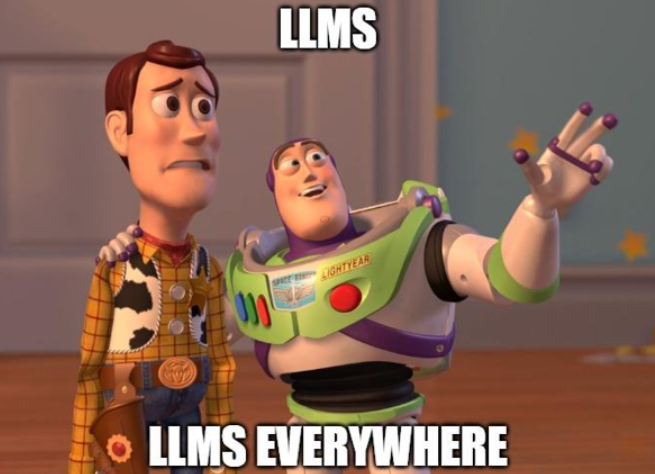